In [1]:
# %load_ext autoreload
# %autoreload 2

import os
import sys
import math
import pickle
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


from src.config import (
    PROCESSED_DATA_DIR,
)
from src import my_utils, community_detection, structural_analysis

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'bayanpy', 'graph_tool', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


In [2]:
@dataclass
class Params:
    min_co_occurence_threshold: int = 5
    ws_rewire_probe: float = 0.8
    k_clique_percolation_base: int = 6 # (finding communities based on N-cliques)
    louvain_communities_resolution: float = 1 #  If resolution is less than 1, the algorithm favors larger communities. Greater than 1 favors smaller communities

params = Params()

# 1. Get Data

## 1.1 Edges Data

In [3]:
edges_data = (
    pd.read_csv(PROCESSED_DATA_DIR / "edges_data_processed.csv")
)

edges_data

name1                name2  total_co_occurance  \
0                 Ammanas               Laseen                  91   
1                 Ammanas  Ganoes Stabro Paran                  33   
2                  Laseen  Ganoes Stabro Paran                  69   
3     Ganoes Stabro Paran               Laseen                   8   
4           Caladan Brood         Dujek Onearm                  94   
...                   ...                  ...                 ...   
4318              Blistig        Tehol Beddict                   8   
4319              Icarium                Ebron                   6   
4320              Icarium        Tehol Beddict                   7   
4321               Sinter         Vastly Blank                   6   
4322  Sandalath Drukorlat               Sinter                   6   

      books_appearance  book_chapter  co_occurance_chapters_cnt  
0                    9             2                         24  
1                    6             2                         16  
2                    8             2                         22  
3                    4             2                          4  
4                    6             2                         19  
...                ...           ...                        ...  
4318                 1            15                          1  
4319                 1            15                          1  
4320                 1            15                          1  
4321                 1            17                          1  
4322                 1            17                          1  

[4323 rows x 6 columns]

## 1.2 Nodes Data

In [4]:
nodes_data = (
    pd.read_csv(PROCESSED_DATA_DIR / "nodes_data_processed.csv")
)
nodes_data.head()

id    norm_name  gender  \
0      Apsalar      apsalar  Female   
1         Lorn         lorn  Female   
2       Aragan       aragan    Male   
3   Tattersail   tattersail  Female   
4  Whiskeyjack  whiskeyjack     NaN   

                                                info profession  \
0  -, aka Sorry, aka not-Apsalar, 9th Squad, Brid...   Assassin   
1                             Adjunct to the Empress    Empress   
2  , staff sergeant Itko Kan, captain Mock's Hold...      Guard   
3  a mage of Malaz Island, Malazan Cadre Sorceres...  Sorceress   
4  once went by Jack, sergeant of the Bridgeburne...      Guard   

   total_words_count  books_appearance  first_book_appearance  \
0              32604                 3                      1   
1              18266                 1                      1   
2                813                 2                      1   
3              25371                 1                      1   
4              47344                 2                      1   

   last_book_appearance  pov_words_per_book_with_pov  ... race_first  \
0                     6                        10868  ...      Human   
1                     1                        18266  ...      Human   
2                     6                          406  ...      Human   
3                     1                        25371  ...      Human   
4                     3                        23672  ...      Human   

     degree closeness  betweenness  eigenvector  pagerank  core_number  \
0  0.079221  0.409181     0.031353     0.151144  0.005883           15   
1  0.016883  0.349132     0.000304     0.050828  0.001354           12   
2  0.001299  0.264996     0.000000     0.002511  0.000283            1   
3  0.031169  0.350120     0.001345     0.069733  0.002319           14   
4  0.077922  0.404278     0.017875     0.143569  0.005861           14   

   k_clique_percolation  louvain_community  asyn_lpa_community  
0                     7                  1                 0.0  
1                     1                  1                 0.0  
2                    -1                  1                 0.0  
3                     1                  1                 0.0  
4                     1                  1                 0.0  

[5 rows x 22 columns]

## 1.3 Create nx.Graph

In [5]:
with open(PROCESSED_DATA_DIR / "graph.pkl", "rb") as f:
    G = pickle.load(f)

largest_cc = max(nx.connected_components(G), key=lambda cc: len(cc))
largest_cc_subgraph = G.subgraph(largest_cc)

# 2. Network Summary

## 2.1 Visualisation

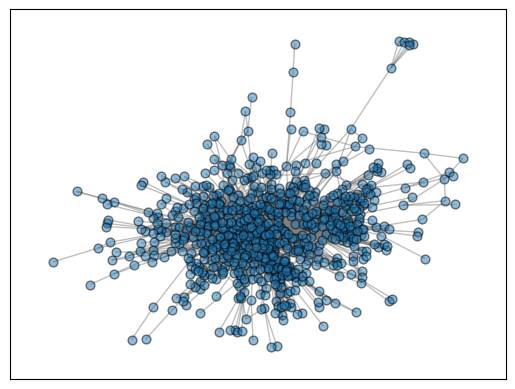

In [6]:
pos = nx.spring_layout(largest_cc_subgraph, k=1/math.sqrt(len(largest_cc_subgraph)), iterations=50, seed=42)
nx.draw_networkx(
    largest_cc_subgraph,
    pos,
    with_labels=False,
    edge_color='gray',
    node_size=40,
    alpha=0.5,
    edgecolors='black'
)

## 2.2 Overview

Number of Connected Components within a Graph: 7
Network Radius (largest CC): 5
Network Diameter (largest CC): 9
Avg. Clustering: 0.52
Avg. Shortest Path Length (largest CC): 3.492


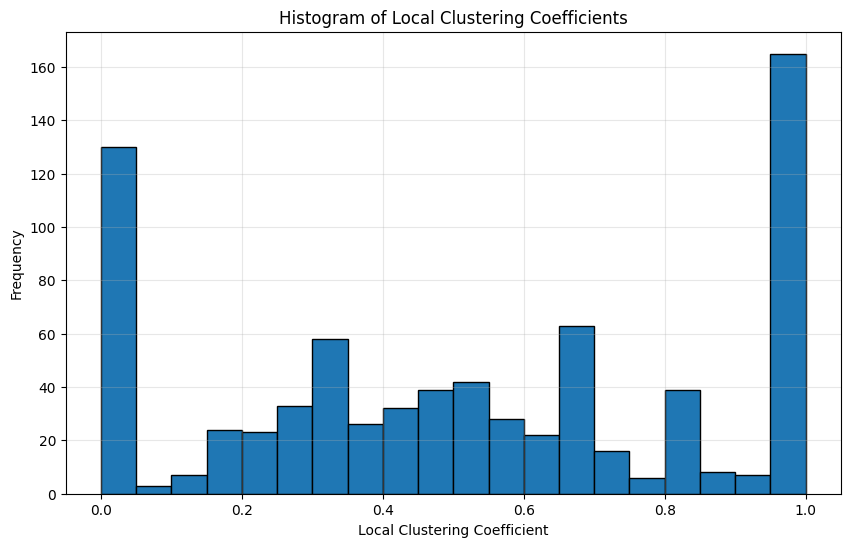

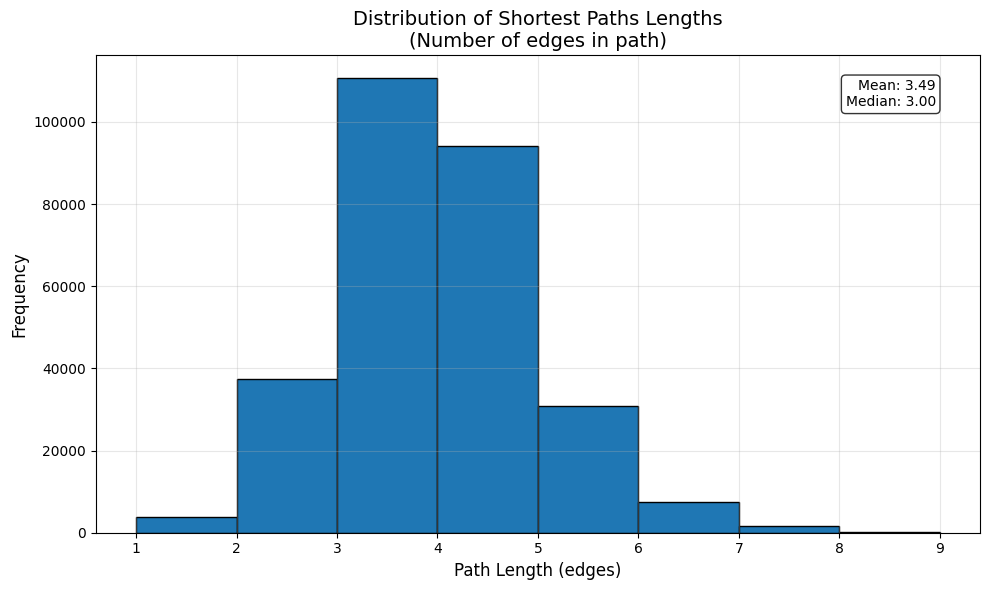

In [7]:
_ = my_utils.get_graph_overview(G)

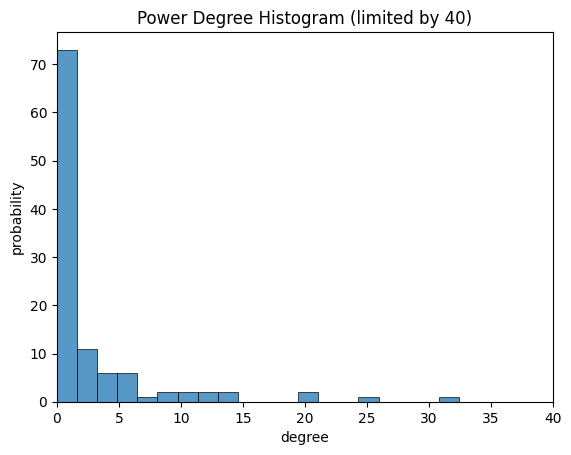

In [8]:
my_utils.plot_power_degree_histogram(G)

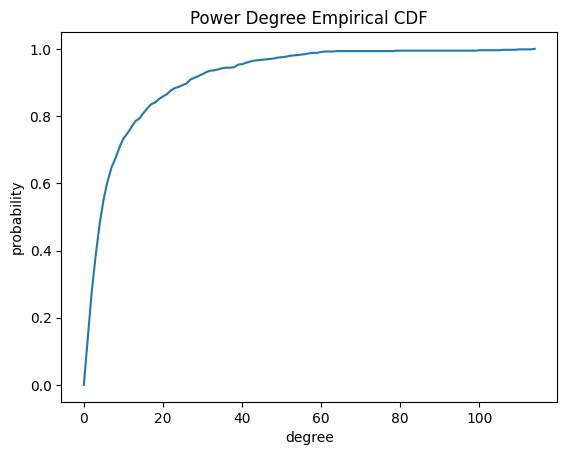

In [9]:
my_utils.plot_power_degree_distribution(G)

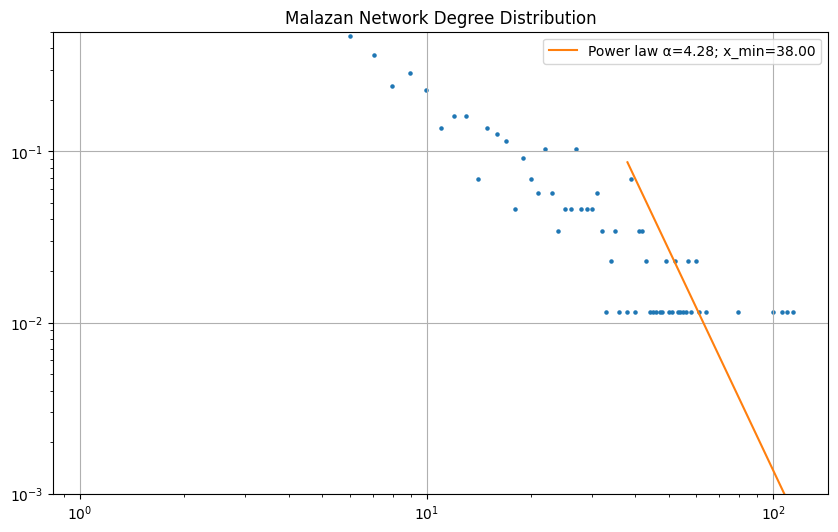

In [10]:
analysis = my_utils.PowerLawAnalysis(G)
analysis.plot_distribution(title='Malazan Network Degree Distribution')

# 3. Structural Analysis

## 3.1 Malazan Network Comparison to Various Random Networks

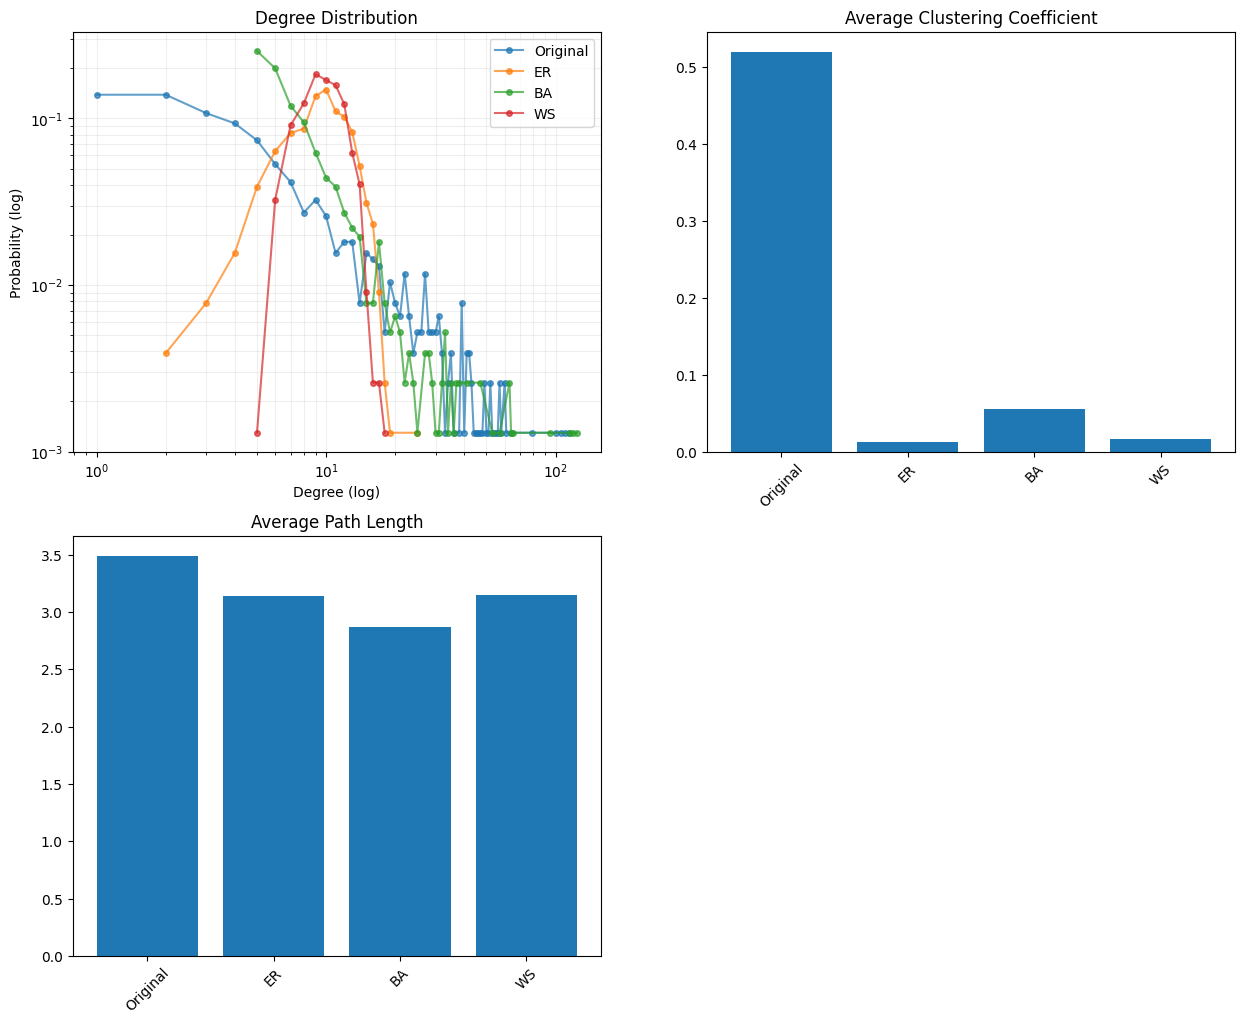

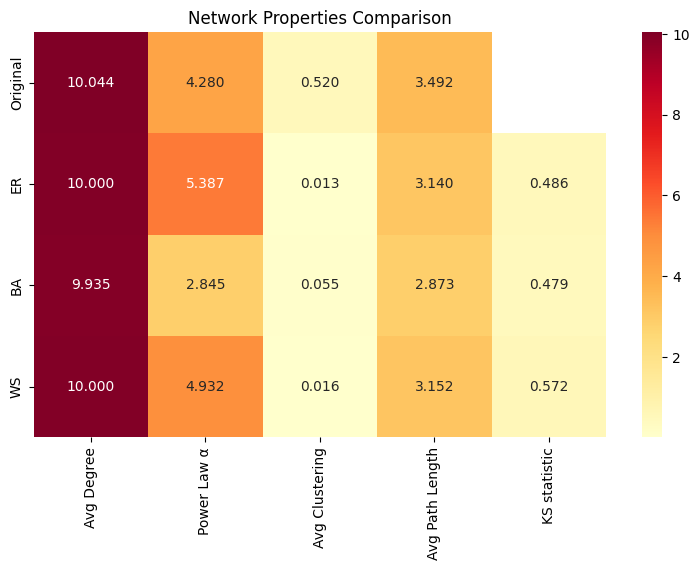

In [11]:
structure_analyser = structural_analysis.NetworkStructuralAnalyser(
    G, ws_rewire_probe=params.ws_rewire_probe
)
_ = structure_analyser.analyze_network_properties()

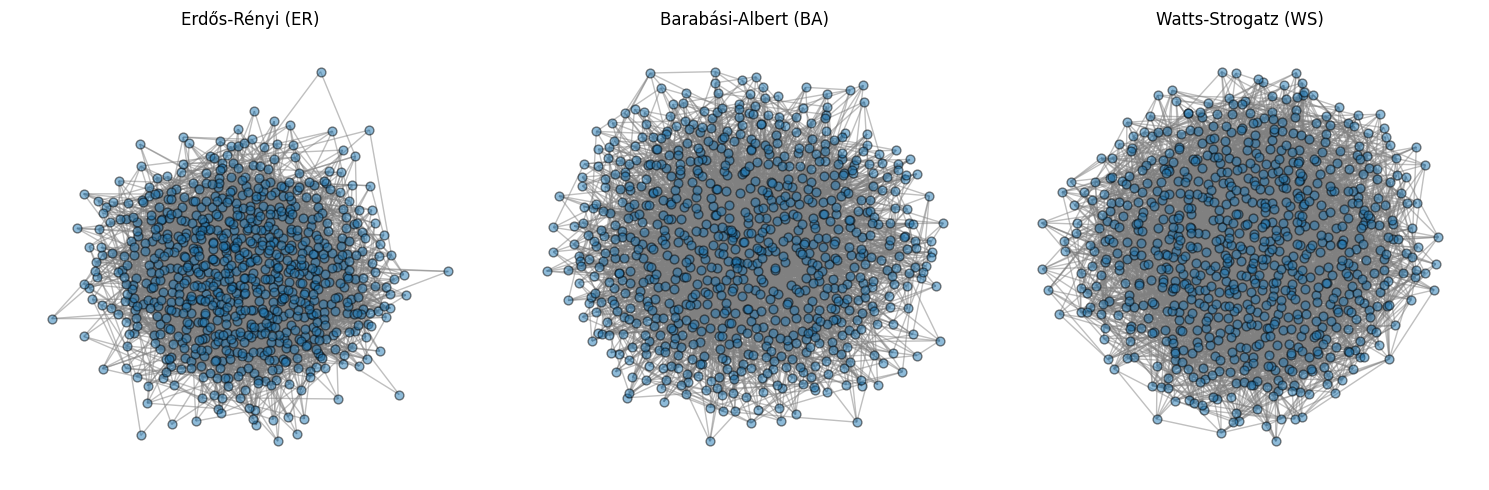

In [12]:
structure_analyser.plot_random_networks()

## 2.2 Centralities

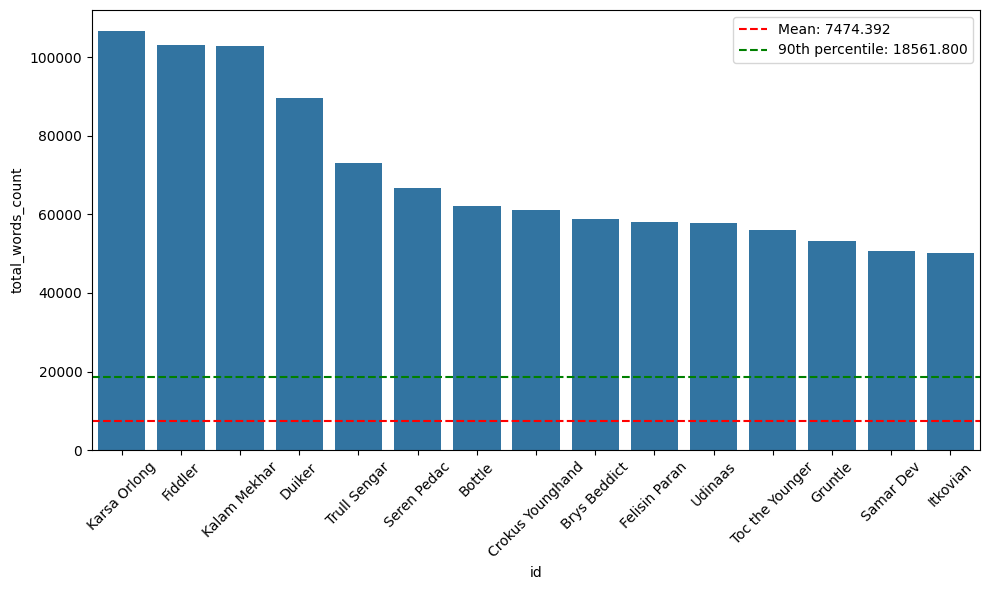

In [13]:
structural_analysis.get_centrality(nodes_data, column_name='total_words_count', centrality_name='pov')

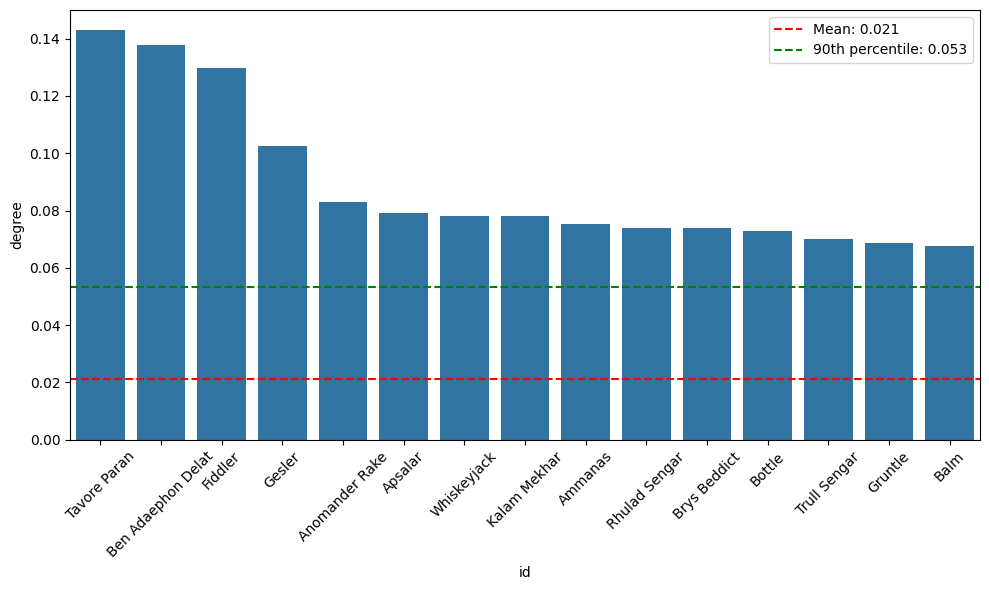

In [14]:
structural_analysis.get_centrality(nodes_data, column_name='degree', centrality_name='degree')

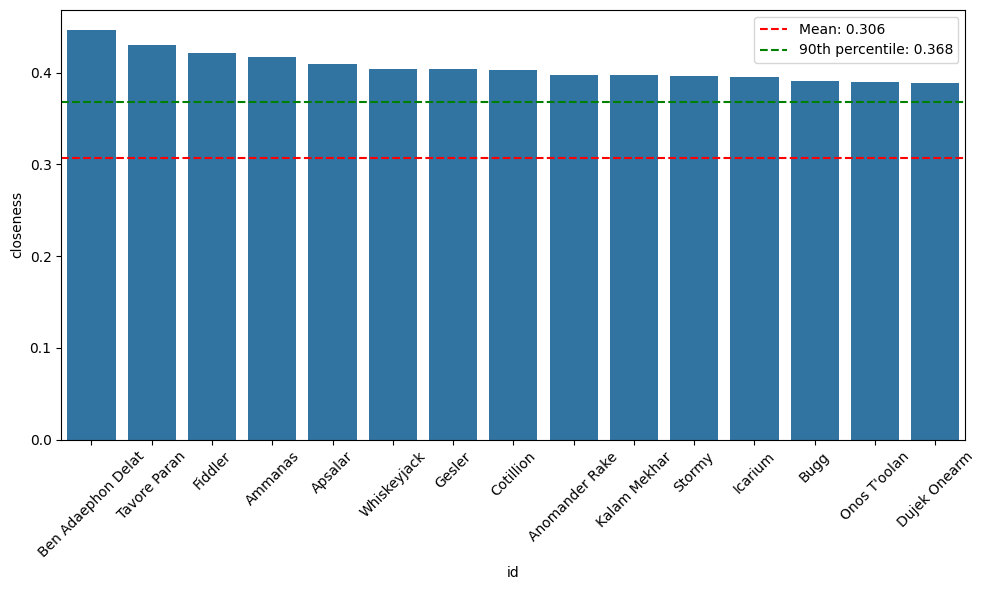

In [15]:
structural_analysis.get_centrality(nodes_data, column_name='closeness', centrality_name='closeness')

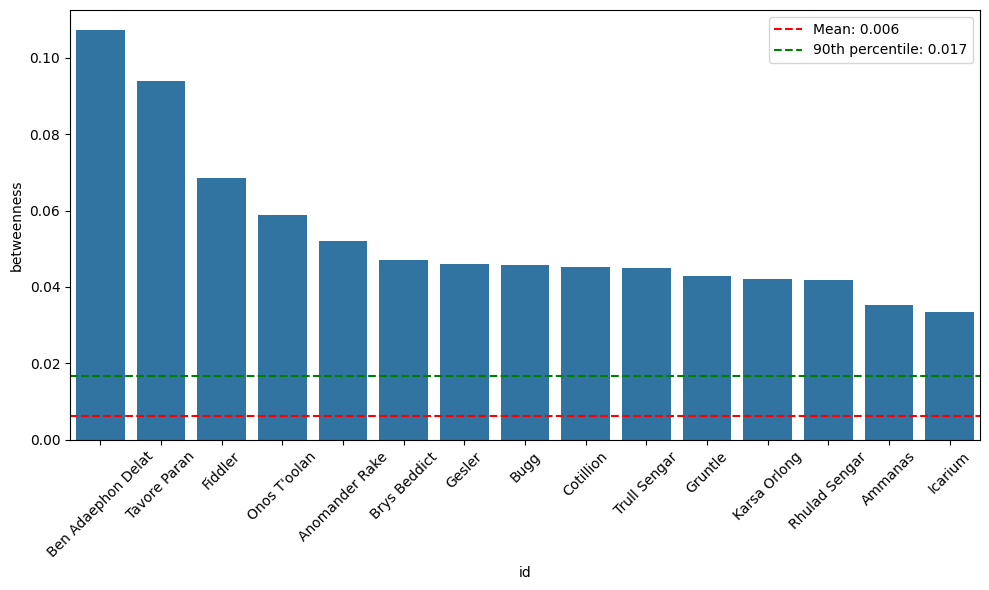

In [16]:
structural_analysis.get_centrality(nodes_data, column_name='betweenness', centrality_name='betweenness')

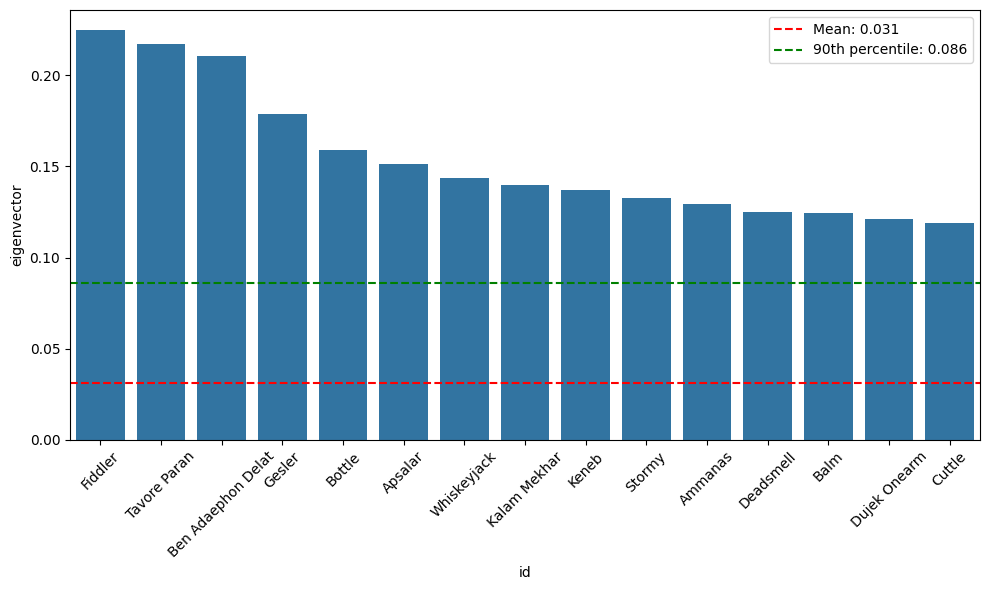

In [17]:
structural_analysis.get_centrality(nodes_data, column_name='eigenvector', centrality_name='eigenvector')

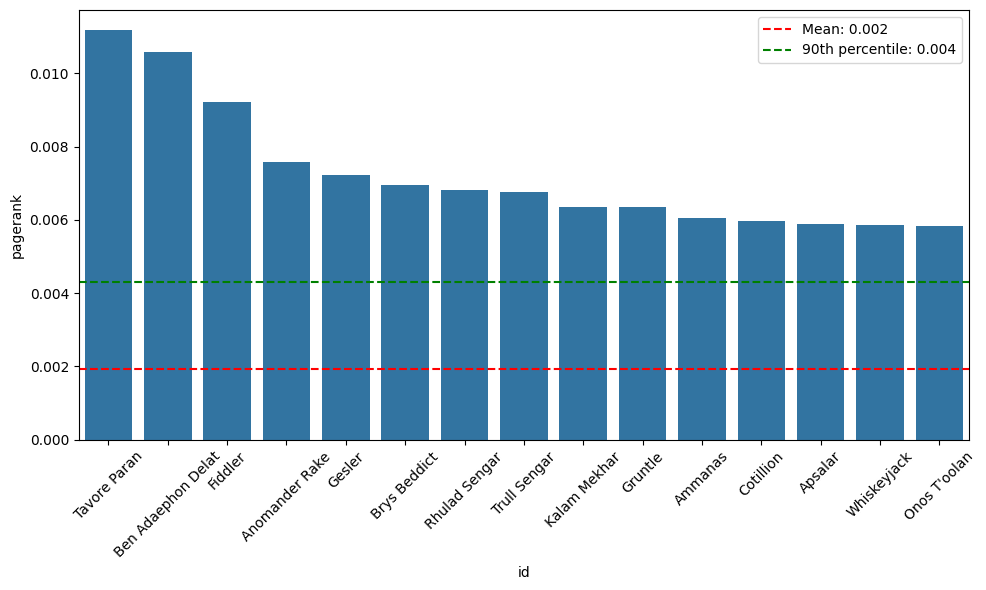

In [18]:
structural_analysis.get_centrality(nodes_data, column_name='pagerank', centrality_name='pagerank')

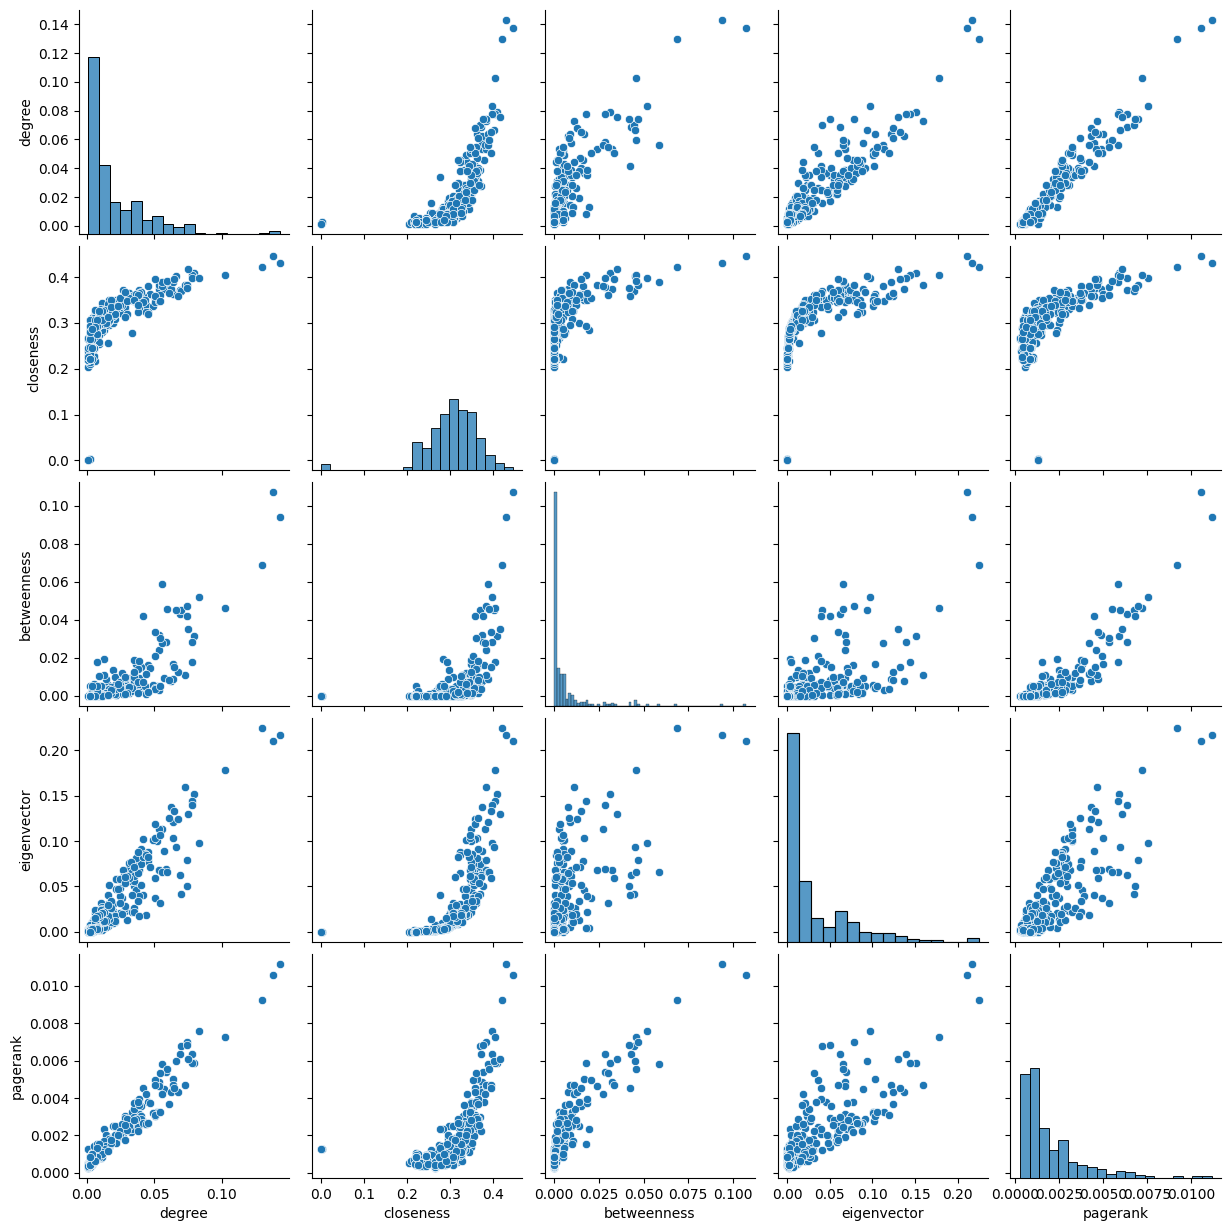

In [19]:
structural_analysis.plot_centralities_pairplot(nodes_data)

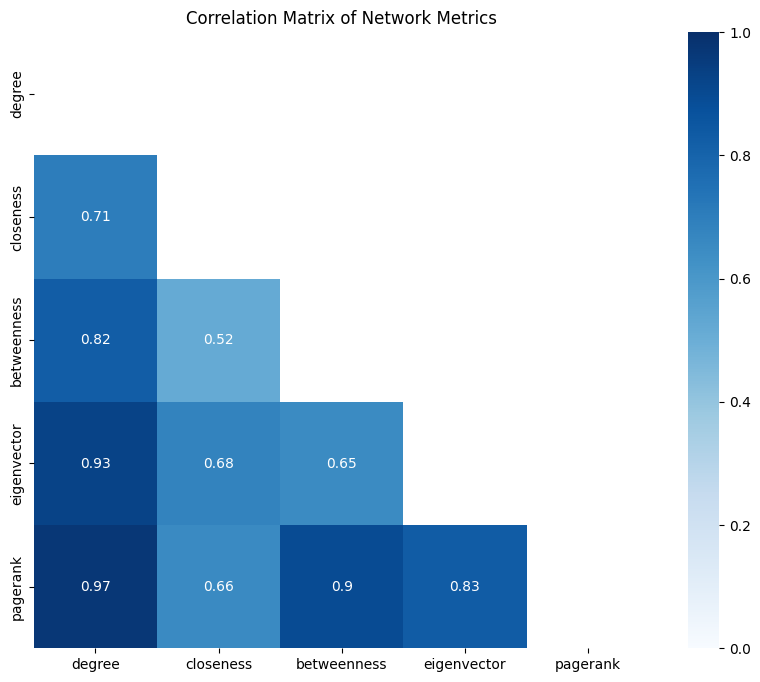

In [20]:
structural_analysis.plot_centralities_corr_matrix(nodes_data)

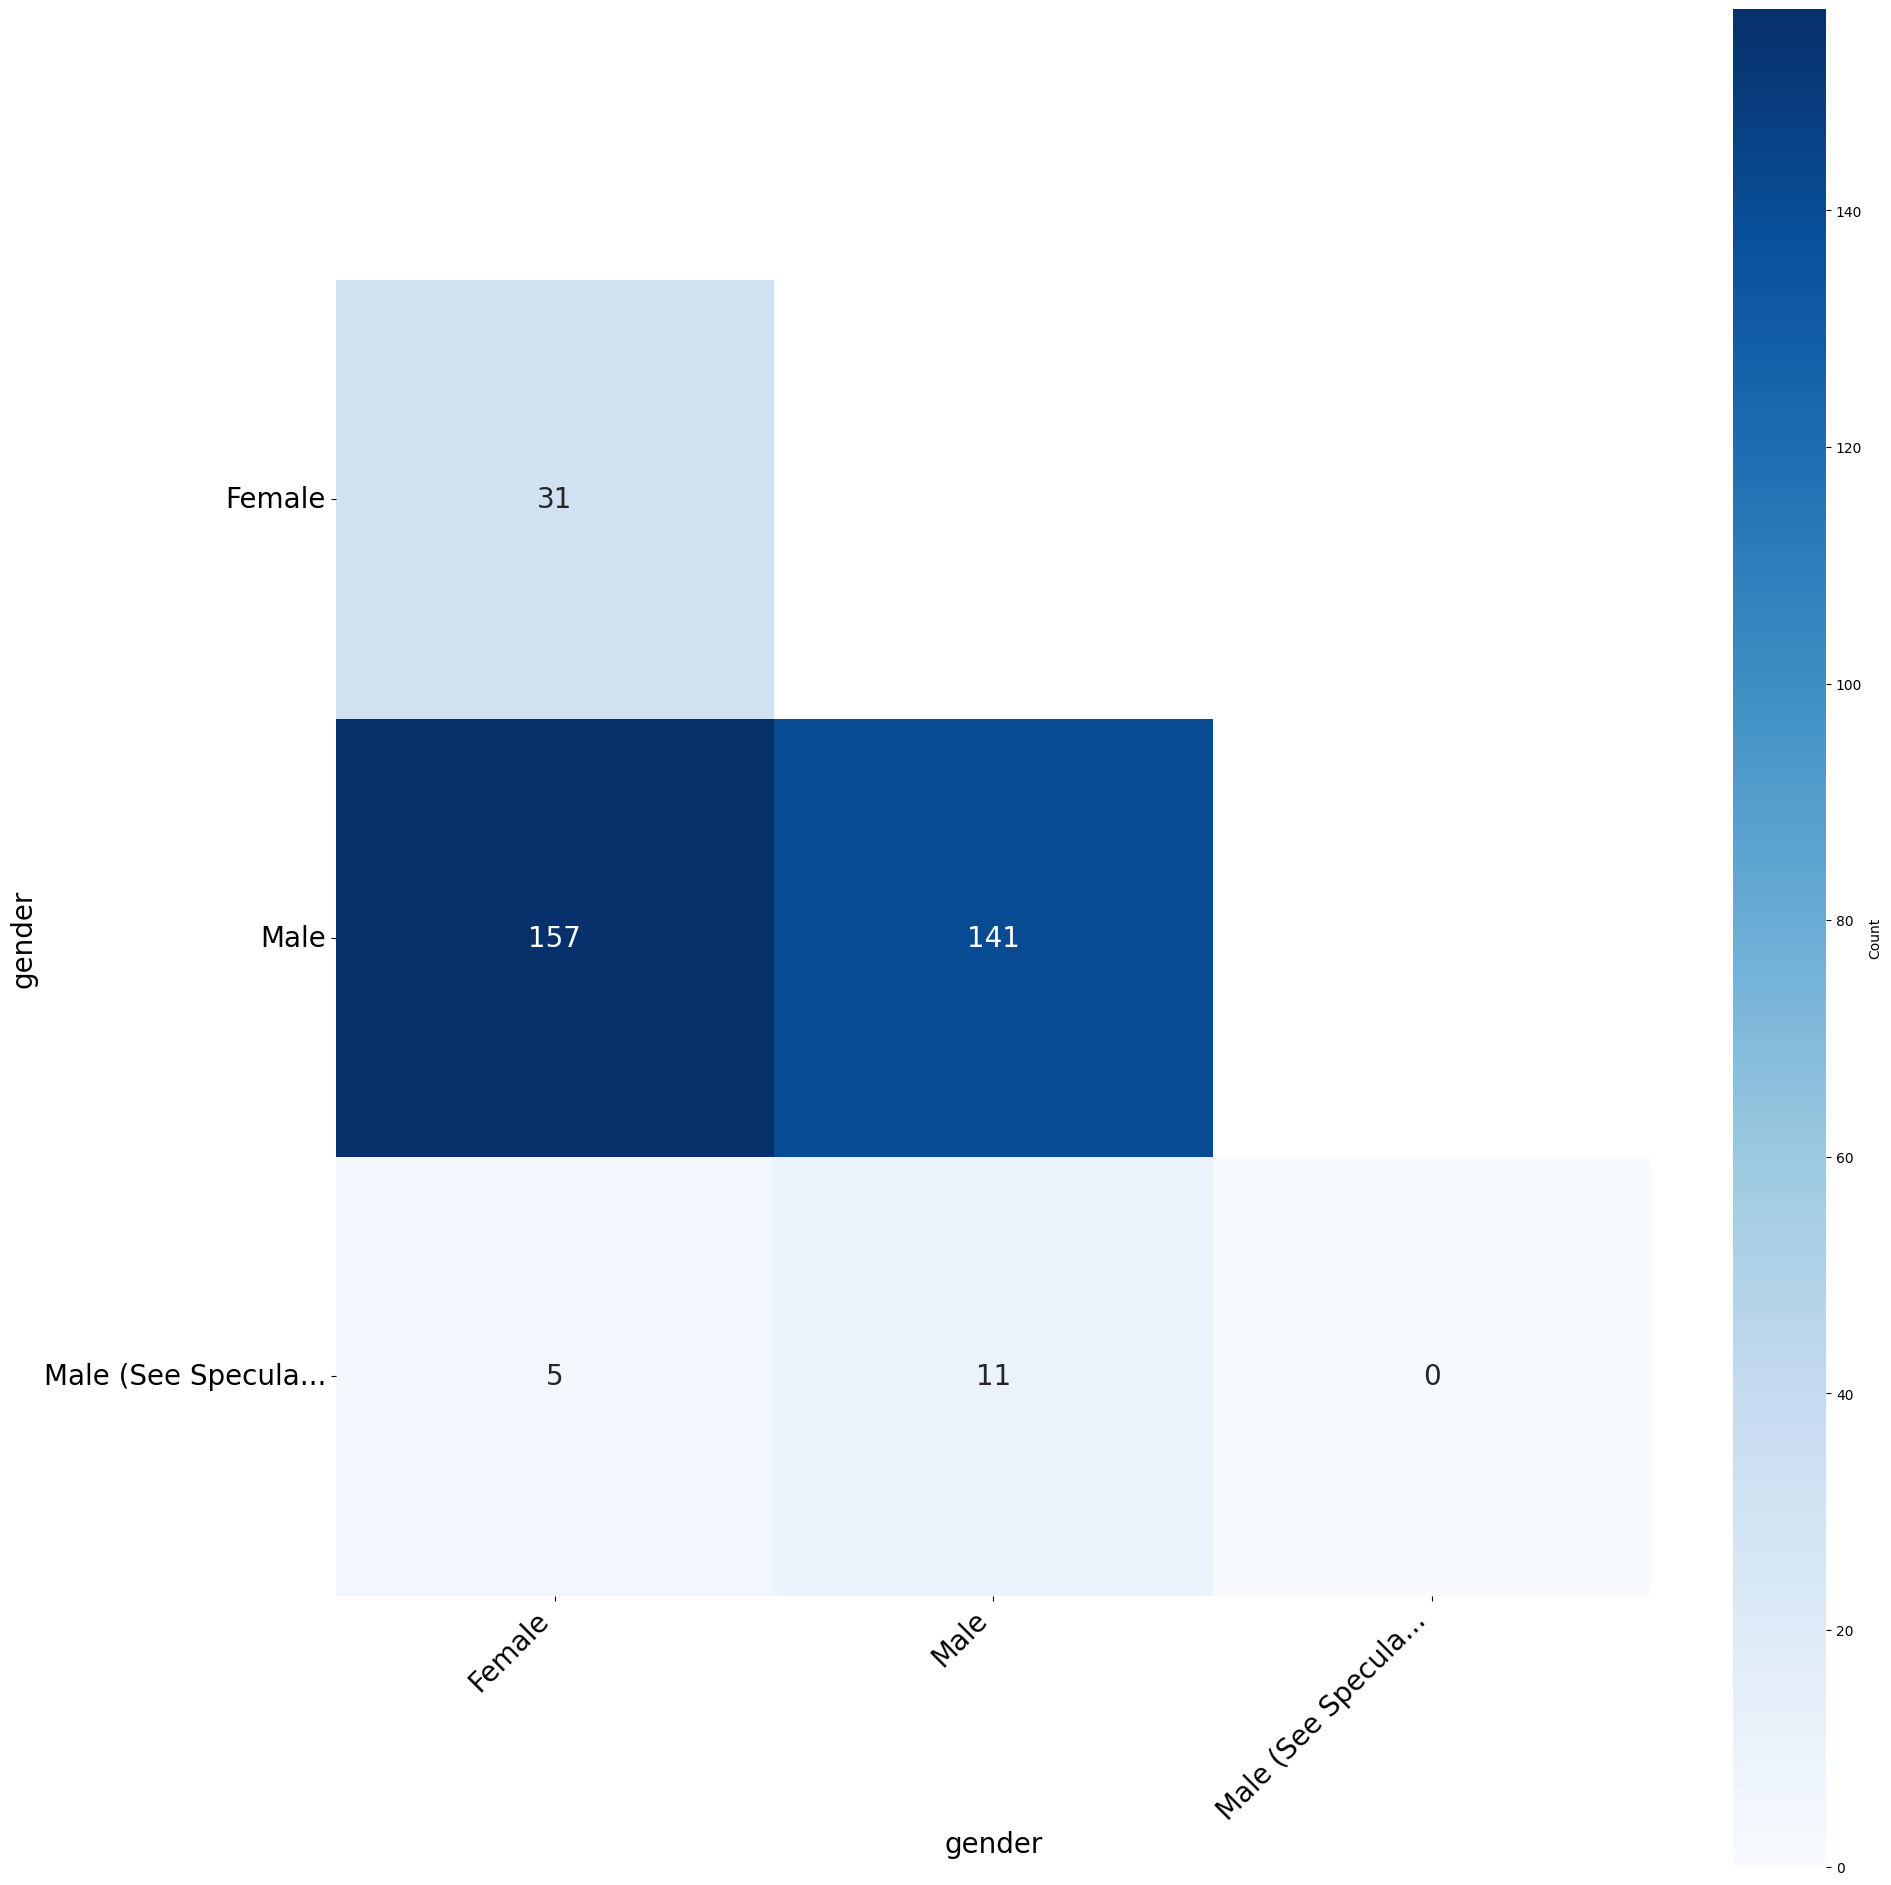

In [21]:
structure_analyser.plot_attribute_mixing(G, 'gender')

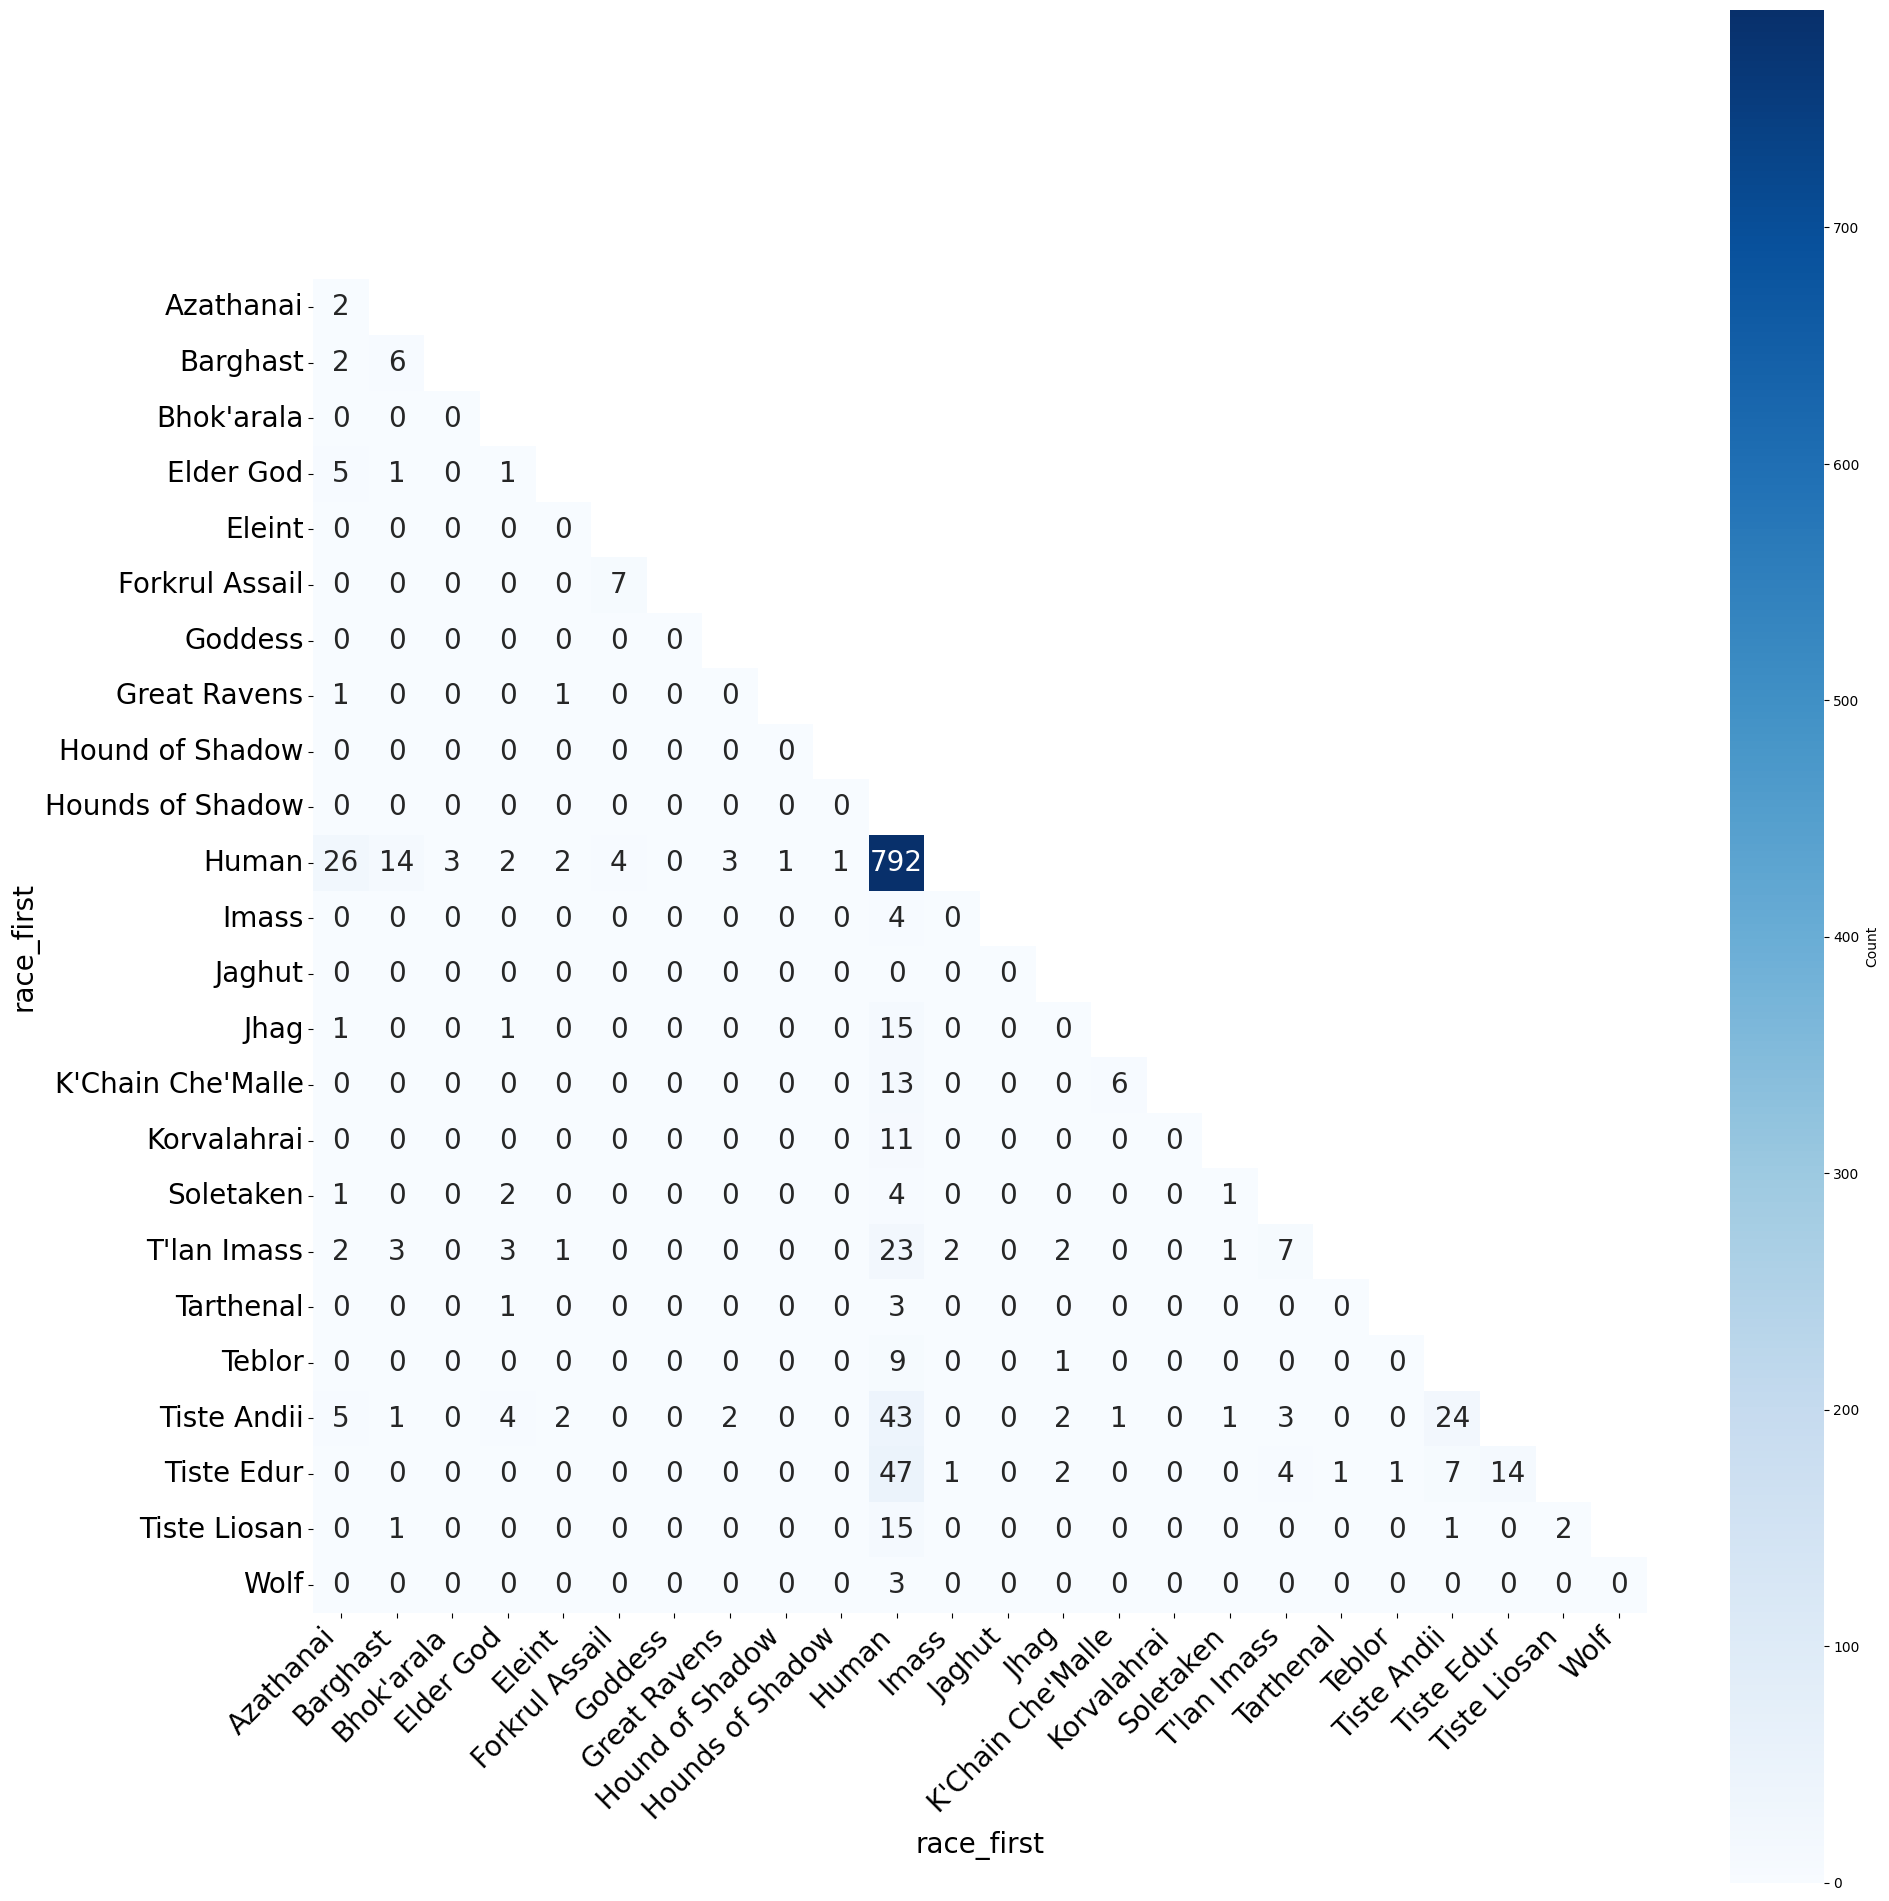

In [22]:
structure_analyser.plot_attribute_mixing(G, 'race_first')

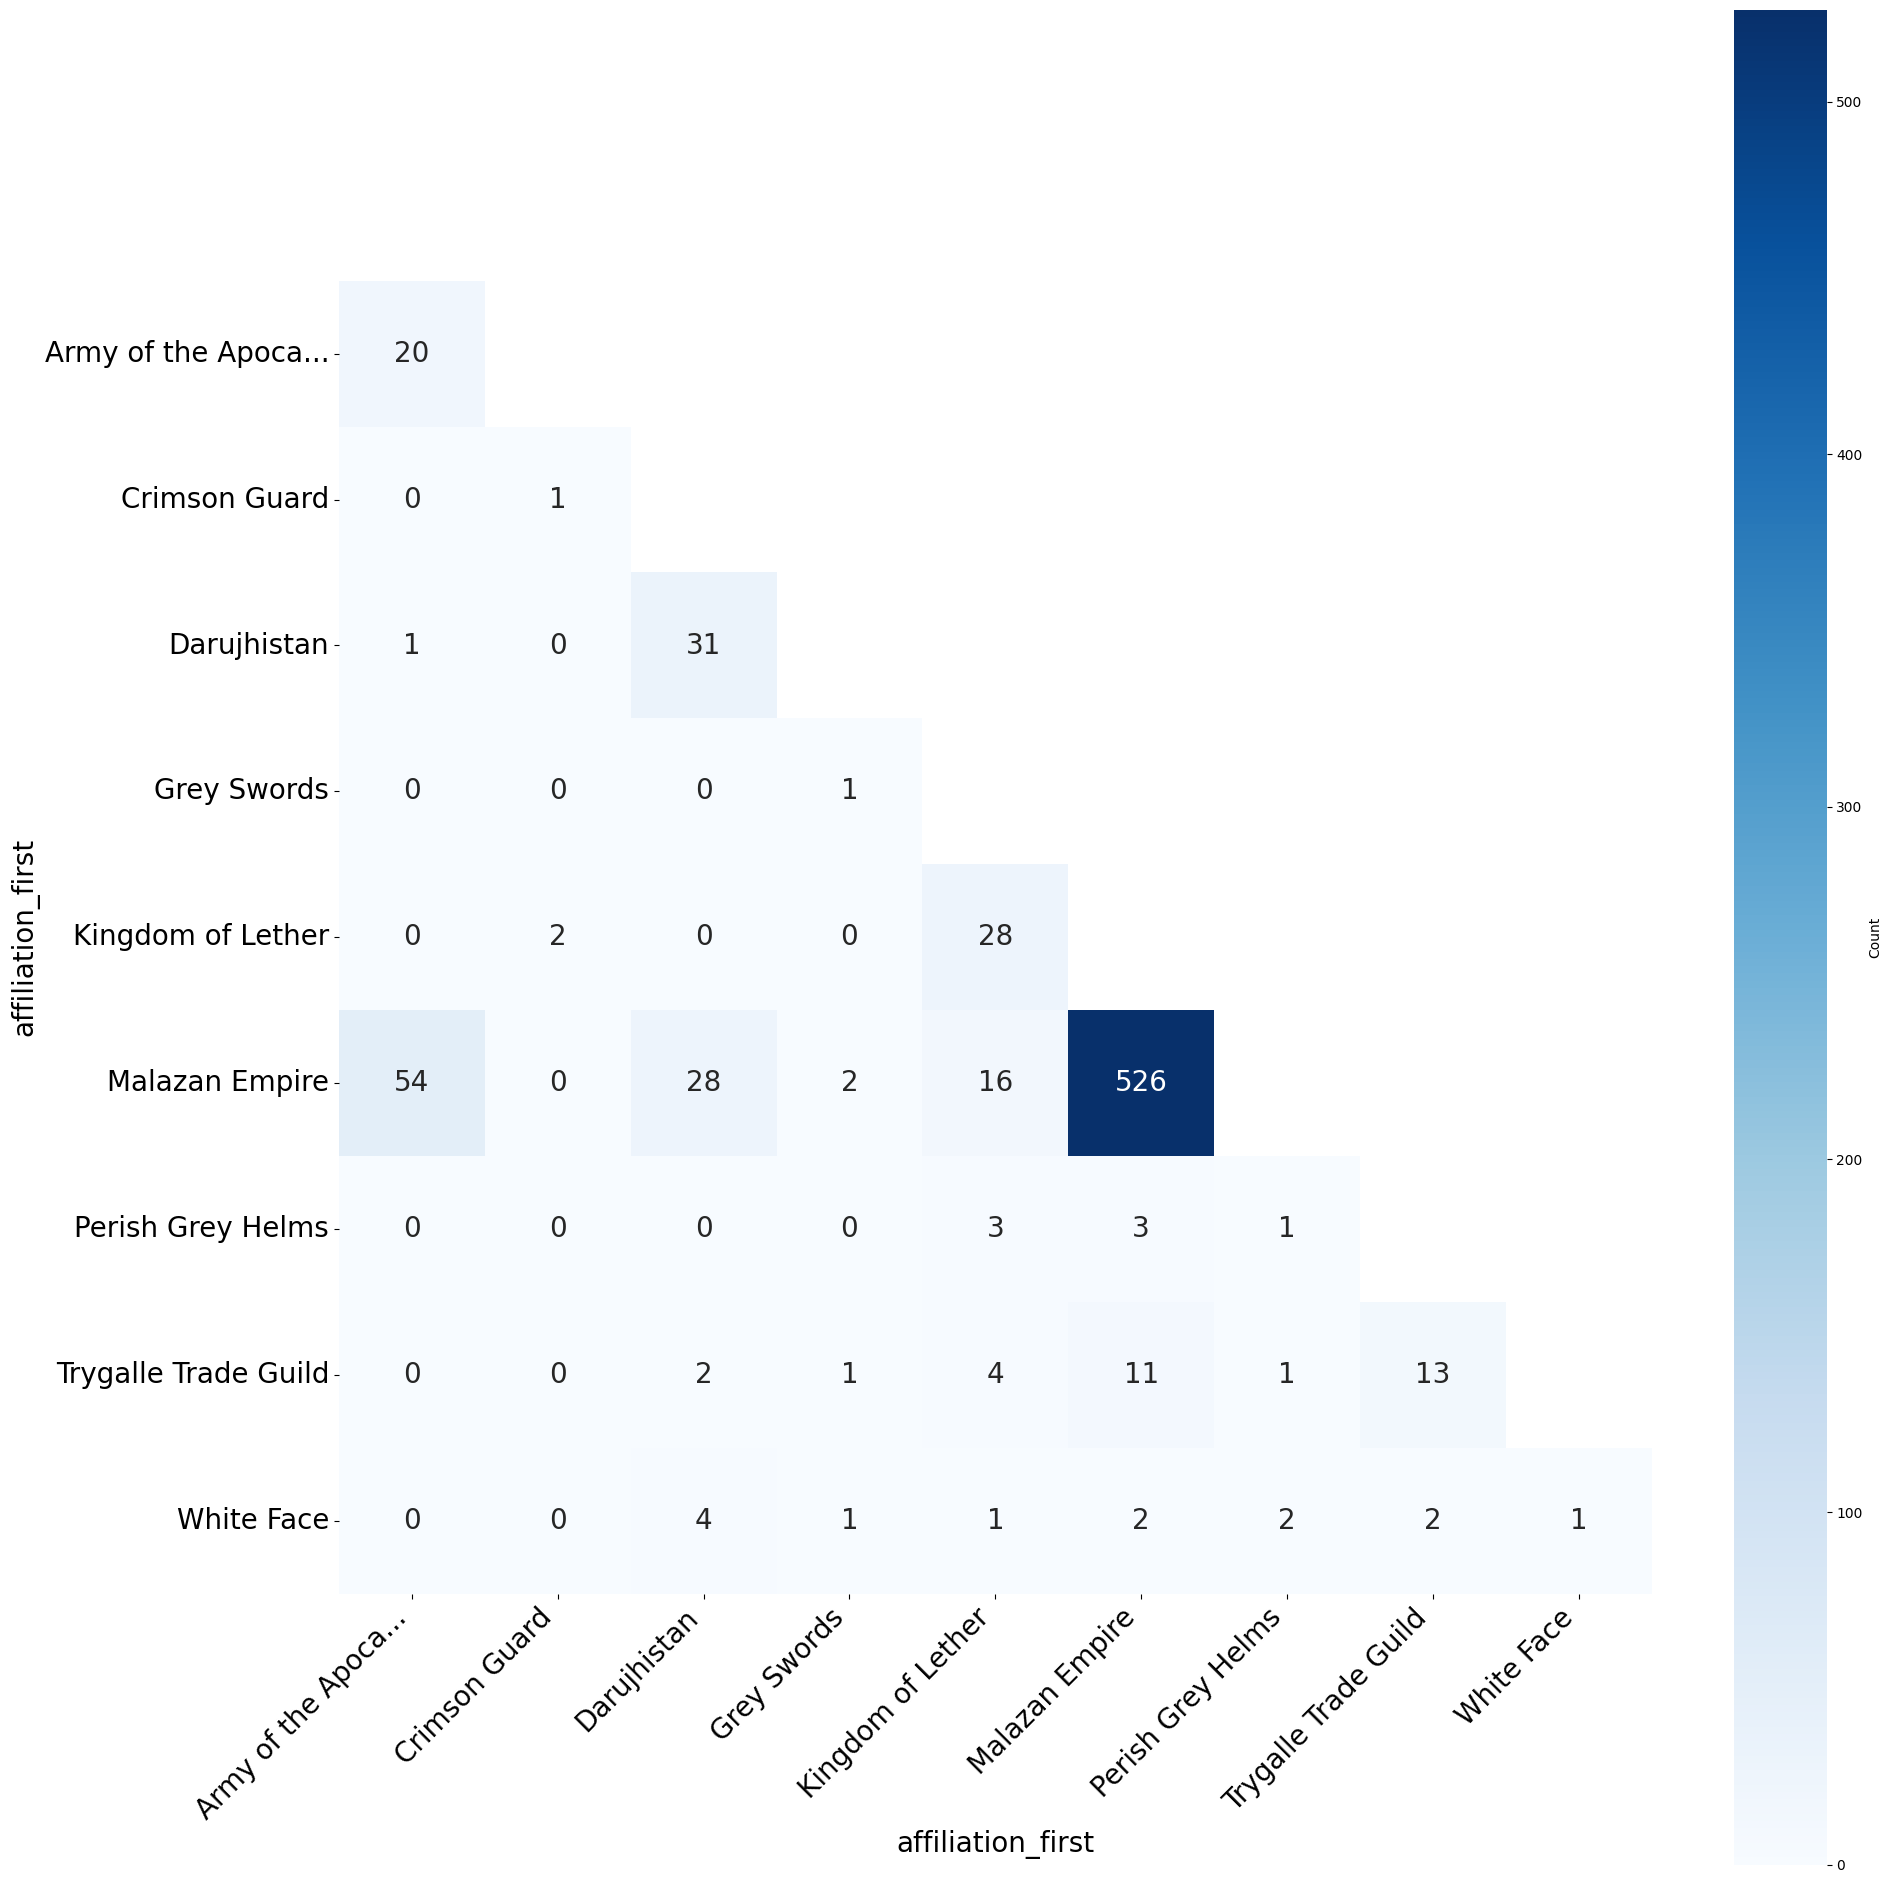

In [23]:
structure_analyser.plot_attribute_mixing(G, 'affiliation_first')

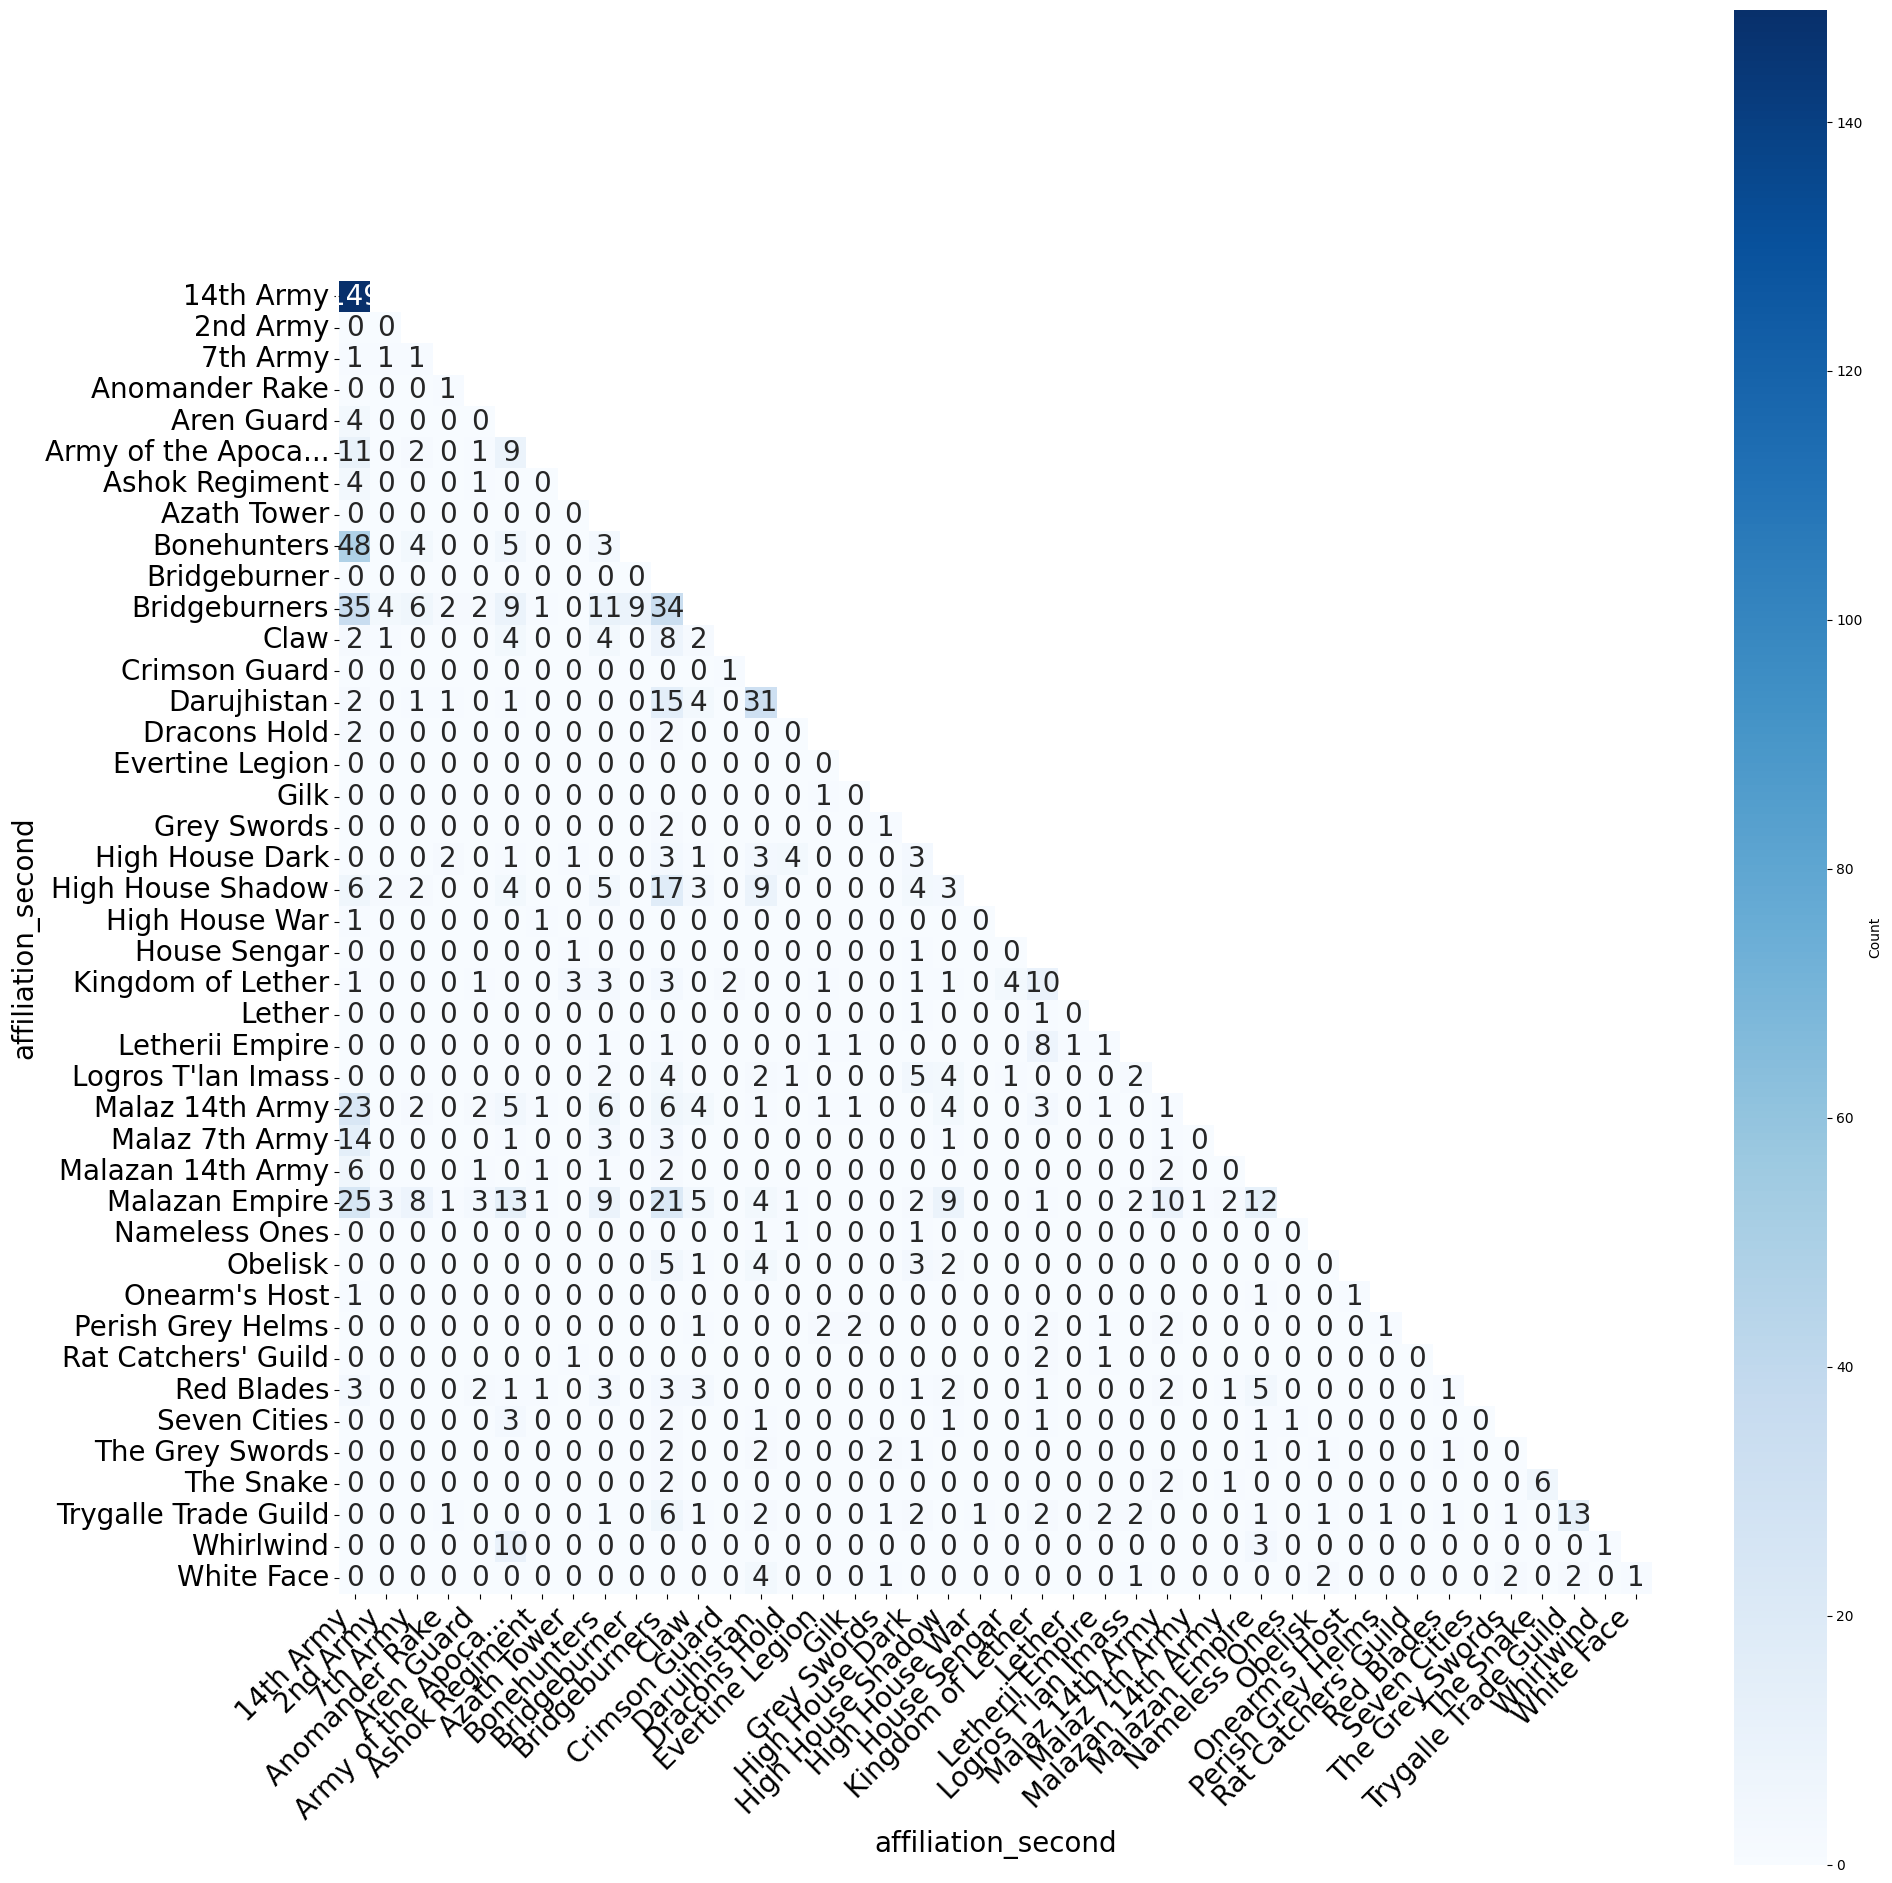

In [24]:
structure_analyser.plot_attribute_mixing(G, 'affiliation_second')

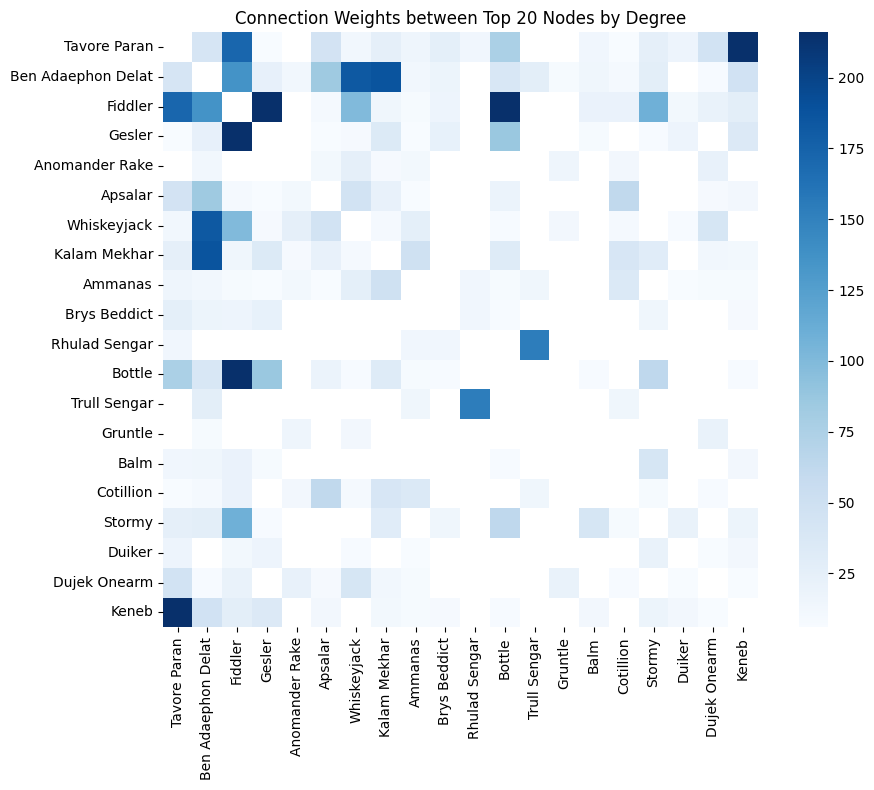

In [25]:
structural_analysis.get_weights_between_top_nodes(nodes_data, G)

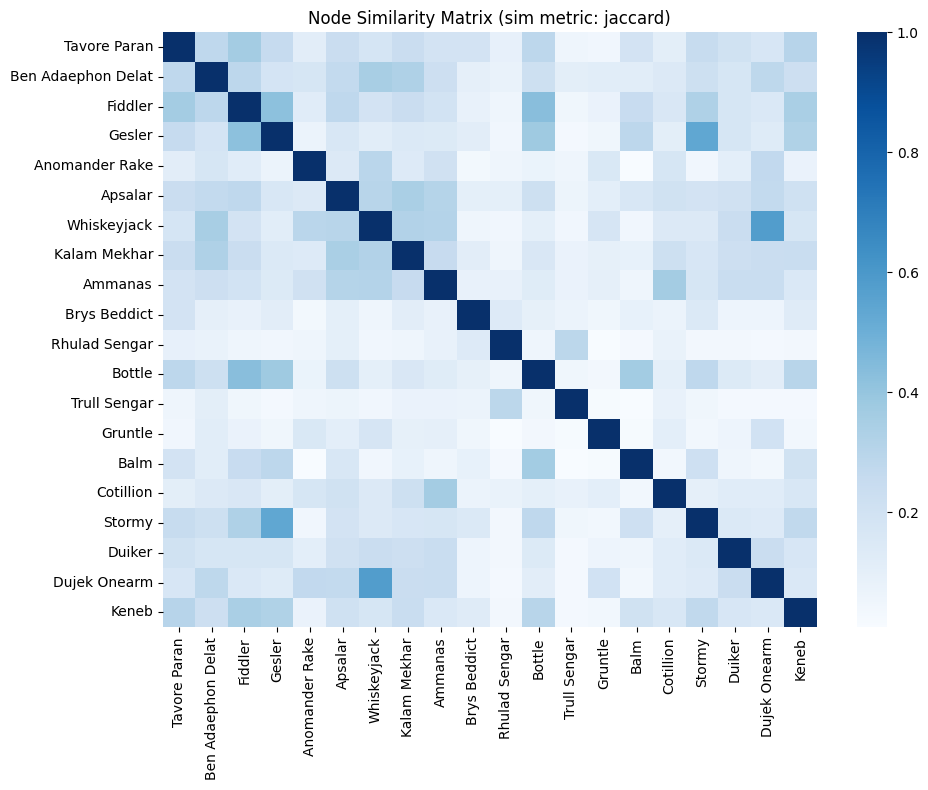

In [26]:
structure_analyser.plot_node_similarity_matrix(
    G, top_nodes=nodes_data.nlargest(20, 'degree')['id'].tolist(), similarity_metric='jaccard'
    )

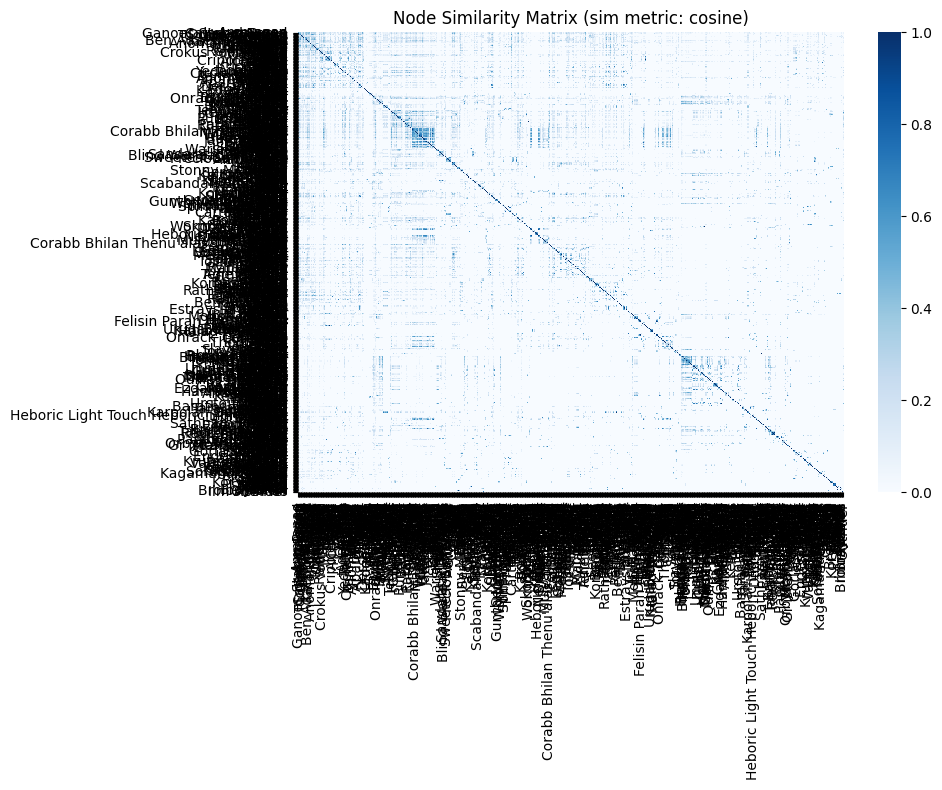

In [27]:
structure_analyser.plot_node_similarity_matrix(
    G, similarity_metric='cosine'
)

# 3. Community Detection

In [28]:
community_detection.get_clique_size_distribution(G)

Size  Count
0     15      2
1     13      8
2     12     10
3     11     24
4     10     58
5      9    104
6      8    177
7      7    204
8      6    216
9      5    220
10     4    254
11     3    226
12     2    185

In [29]:
community_detection.find_top_n_cliques(G, 3)


Top 3 cliques found:

Clique 1:
Size: 15
Node IDs: ['Balm', 'Bottle', 'Deadsmell', 'Flashwit', 'Hellian', 'Jamber Bole', 'Kisswhere', 'Koryk', 'Limp', 'Masan Gilani', 'Mayfly', 'Sinter', 'Smiles', 'Tarr', 'Throatslitter']

Clique 2:
Size: 15
Node IDs: ['Balm', 'Bottle', 'Deadsmell', 'Flashwit', 'Hellian', 'Jamber Bole', 'Kisswhere', 'Koryk', 'Limp', 'Mayfly', 'Sinter', 'Smiles', 'Tarr', 'Throatslitter', 'Widdershins']

Clique 3:
Size: 13
Node IDs: ['Clasp', 'Deadsmell', 'Flashwit', 'Hellian', 'Jamber Bole', 'Kisswhere', 'Limp', 'Masan Gilani', 'Mayfly', 'Nep Furrow', 'Reliko', 'Sinter', 'Tarr']


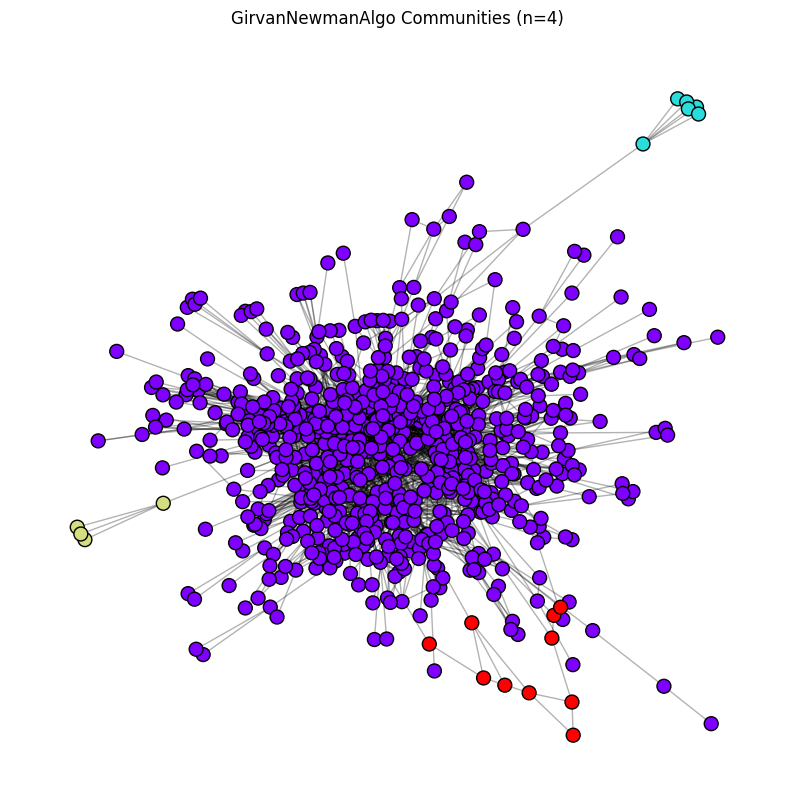

In [30]:
gn = community_detection.GirvanNewmanAlgo(largest_cc_subgraph)
labels = gn.run(3)
gn.plot_communities()

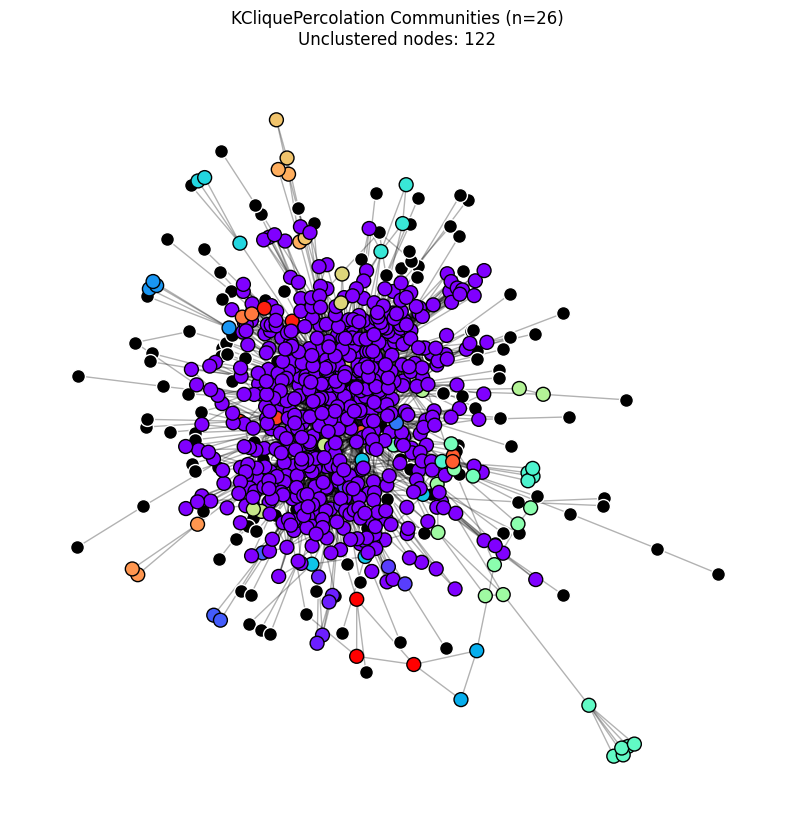

In [31]:
kc = community_detection.KCliquePercolation(largest_cc_subgraph)
communities = kc.run(k=3)
kc.plot_communities()

2024-11-30 13:31:45.734 | INFO     | src.community_detection:print_communities:122 - Found 13 communities:
2024-11-30 13:31:45.755 | INFO     | src.community_detection:print_communities:124 - Community 1: [' Dark', 'Adaephon', 'Admiral Nok', 'Aimless', 'Alchemist', 'Ammanas', 'Anaster', 'Anomander Rake', 'Antsy', 'Apsalar', 'Apto', 'Aragan', 'Artanthos', 'Baruk', 'Bellurdan', 'Ben Adaephon Delat', 'Bendal Home', 'Blend', 'Bluepearl', 'Boil', 'Braven', 'Brukhalian', 'Bucklund', 'Bude', 'Cafal', 'Caladan Brood', 'Calot', 'Cannig Tol', 'Chained', 'Chal', 'Challice', 'Chole', 'Circle Breaker', 'Coll', 'Coop', 'Crippled God', 'Crone', 'Crust', "D'Arle", 'Darist', 'Dathenar', 'Dela', 'Derudan', 'Dessembrae', 'Detoran', 'Dujek Onearm', 'Durav', 'Endest', 'Endest Silann', "Estraysian D'Arle", 'Farakalian', 'Futhgar', 'Ganath', 'Ganoes Stabro Paran', 'Garsten', 'Gent', 'Gethol', 'Gorlas', 'Gorlas Vidikas', 'Gradithan', 'Gran', 'Hairlock', 'Hanut Orr', 'Hedge', 'Herald', 'Hetan', 'Hinter', 'Humb

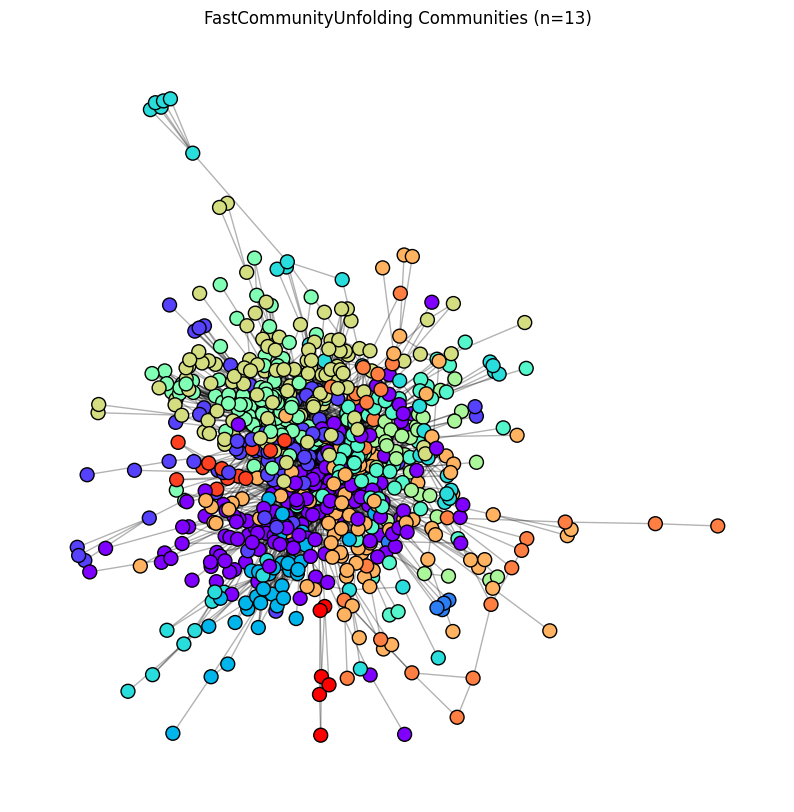

In [32]:
fcu = community_detection.FastCommunityUnfolding(largest_cc_subgraph)
communities = fcu.run()
fcu.print_communities()
fcu.plot_communities()

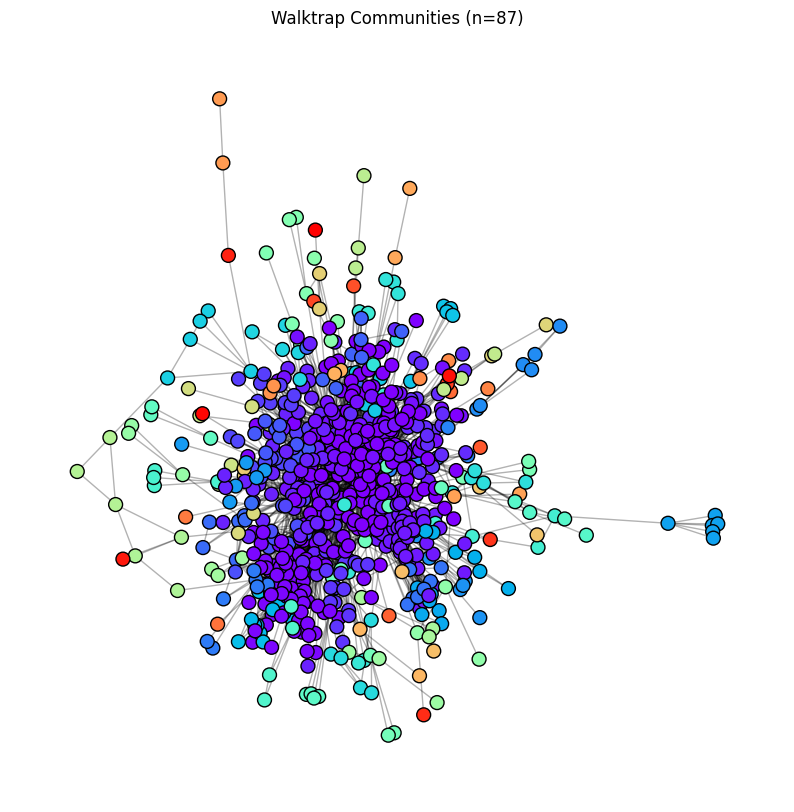

In [33]:
wt = community_detection.Walktrap(largest_cc_subgraph)
communities = wt.run()
wt.plot_communities()

2024-11-30 13:31:48.486 | INFO     | src.community_detection:run:258 - Successfully detected 73 communities using LPA


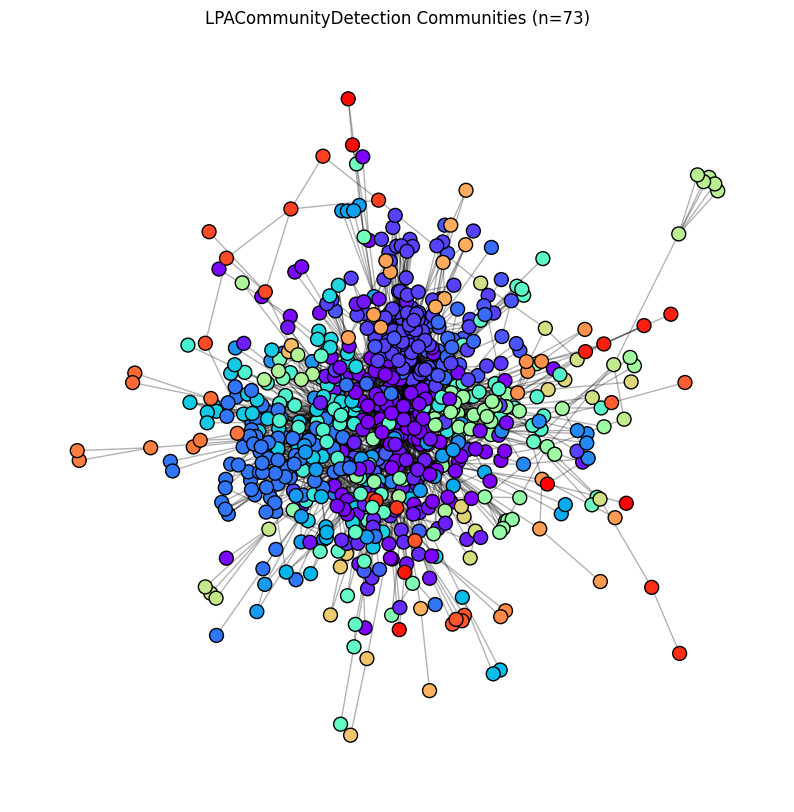

In [34]:
lpa = community_detection.LPACommunityDetection(largest_cc_subgraph, weight='total_co_occurance')
communities = lpa.run()
lpa.plot_communities()